In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/english-word-hx/words.txt
/kaggle/input/autogluon-gpu/python_multipart-0.0.9-py3-none-any.whl
/kaggle/input/autogluon-gpu/attrs-23.2.0-py3-none-any.whl
/kaggle/input/autogluon-gpu/nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl
/kaggle/input/autogluon-gpu/text_unidecode-1.3-py2.py3-none-any.whl
/kaggle/input/autogluon-gpu/spacy_loggers-1.0.5-py3-none-any.whl
/kaggle/input/autogluon-gpu/aiosignal-1.3.1-py3-none-any.whl
/kaggle/input/autogluon-gpu/triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl
/kaggle/input/autogluon-gpu/soupsieve-2.5-py3-none-any.whl
/kaggle/input/autogluon-gpu/packaging-24.0-py3-none-any.whl
/kaggle/input/autogluon-gpu/lit-18.1.2.tar.gz
/kaggle/input/autogluon-gpu/croniter-1.4.1-py2.py3-none-any.whl
/kaggle/input/autogluon-gpu/blessed-1.20.0-py2.py3-none-any.whl
/kaggle/input/autogluon-gpu/googleapis_common_protos-1.63.0-py2.py3-none-any.whl
/kaggle/input/autogluon-gpu/joblib-1.3.2-py3-none-any.whl
/kaggle/input/auto

Project Overview:
Automated Essay Scoring with Open-Source Solutions Background The first automated essay scoring competition, the Automated Student Assessment Prize (ASAP), was held twelve years ago. Since then, advancements in Automated Writing Evaluation (AWE) systems have aimed to reduce the time and cost associated with manual grading of student essays. However, many of these advancements are not widely accessible due to cost barriers, limiting their impact, especially in underserved communities.

Goal The goal of this competition
is to develop an open-source essay scoring algorithm that improves upon the original ASAP competition. By leveraging updated datasets and new ideas, the aim is to provide reliable and accessible automated grading solutions to overtaxed teachers, particularly in underserved communities. The competition seeks to reduce the high expense and time required for manual grading and enable the introduction of essays into testing, a key indicator of student learning.

Dataset
The competition utilizes the largest open-access writing dataset aligned with current standards for student-appropriate assessments. The dataset includes high-quality, realistic classroom writing samples, addressing the limitations of previous efforts by encompassing diverse economic and location populations to mitigate potential algorithmic bias. The dataset focuses on common essay formats used in classroom settings, providing a more expansive and representative sample for training and evaluation. Approach

Data Loading,
We begin by importing the necessary libraries for our task, including pandas, matplotlib.pyplot, seaborn, numpy, and torch. Data Loading We load the training data from a CSV file using pandas read_csv function. The df_train DataFrame now holds our training data

In [2]:
import gc
import torch
import copy
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
import nltk
from datasets import Dataset
from glob import glob
import numpy as np 
import pandas as pd
import polars as pl
import re
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.special import softmax
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
import lightgbm as lgb
nltk.download('wordnet')


2024-05-02 17:17:36.406892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 17:17:36.407016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 17:17:36.547627: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [3]:
MAX_LENGTH = 1024
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from scipy.special import softmax
import torch
import gc
import glob
MODEL_PATHS = [
    '/kaggle/input/aes2-400-20240419134941/*/*',
    '/kaggle/input/best-model-1/deberta-large-fold1/checkpoint-100/',
    '/kaggle/input/train-best-model-3/deberta-large-fold1/checkpoint-200/'
]
EVAL_BATCH_SIZE = 1

models = []
for path in MODEL_PATHS:
    models.extend(glob.glob(path))

tokenizer = AutoTokenizer.from_pretrained(models[0])

def tokenize(sample):
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

df_test = pd.read_csv(TEST_DATA_PATH)
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=EVAL_BATCH_SIZE, 
    report_to="none"
)

predictions = []
for model in models:
    model = AutoModelForSequenceClassification.from_pretrained(model)
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=DataCollatorWithPadding(tokenizer), 
        tokenizer=tokenizer
    )    
    preds = trainer.predict(ds).predictions
    predictions.append(softmax(preds, axis=-1))
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [4]:
predicted_score = 0.
for p in predictions:
    predicted_score += p
    
predicted_score /= len(predictions)


In [5]:
df_test['score'] = predicted_score.argmax(-1) + 1
df_test.head()


,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,5


In [6]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)

train.head(1)

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people ha…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"


In [7]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

In [8]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

with open('/kaggle/input/english-word-hx/words.txt', 'r') as file:
    english_vocab = set(word.strip().lower() for word in file)
    
def count_spelling_errors(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_.lower() for token in doc]
    spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
    return spelling_errors

In [9]:
import string
def remove_punctuation(text):
    """
    Remove all punctuation from the input text.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The text with punctuation removed.
    """

    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [10]:
def Paragraph_Preprocess(tmp):

    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
    tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp

# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea
def Paragraph_Eng(train_tmp):
    num_list = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600]
    num_list2 = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700]
    aggs = [
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_>{i}_cnt") for i in [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_<{i}_cnt") for i in [25,49]], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  53


,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,...,paragraph_word_cnt_kurtosis,paragraph_error_num_q1,paragraph_len_q1,paragraph_sentence_cnt_q1,paragraph_word_cnt_q1,paragraph_error_num_q3,paragraph_len_q3,paragraph_sentence_cnt_q3,paragraph_word_cnt_q3,score
0,000d118,1,1,1,1,1,1,1,1,1,...,NaN,27.0,2640.0,14.0,491.0,27.0,2640.0,14.0,491.0,3
1,000fe60,5,5,5,5,5,5,5,4,3,...,-1.388460,1.0,235.0,4.0,46.0,1.0,398.0,5.0,77.0,3
2,001ab80,4,4,4,4,4,4,4,4,4,...,-1.696723,1.0,576.0,5.0,101.0,2.0,927.0,8.0,165.0,4


In [11]:
def Sentence_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))    
    return tmp

# feature_eng
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_>{i}_cnt") for i in [0,15,50,100,150,200,250,300] ], 
        *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f"sentence_<{i}_cnt") for i in [15,50] ], 
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in sentence_fea],
    
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)


Features Number:  81


,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,...,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last,sentence_len_kurtosis,sentence_word_cnt_kurtosis,sentence_len_q1,sentence_word_cnt_q1,sentence_len_q3,sentence_word_cnt_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,36,7,0,1,1.438632,2.175806,109.0,19.0,225.0,37.0
1,000fe60,5,5,5,5,5,5,5,4,3,...,62,13,0,1,0.917062,0.505776,51.0,12.0,124.0,25.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,144,27,0,1,-0.004393,0.270079,86.0,17.0,151.0,29.0


In [12]:
# word feature
def Word_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    tmp = tmp.filter(pl.col('word_len')!=0)    
    return tmp

# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(train)
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

Features Number:  102


,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,5,4,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


In [13]:
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,6),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ',len(feature_names))
train_feats.head(3)

Number of Features:  19729


,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,...,tfid_19617,tfid_19618,tfid_19619,tfid_19620,tfid_19621,tfid_19622,tfid_19623,tfid_19624,tfid_19625,tfid_19626
0,000d118,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000fe60,5,5,5,5,5,5,5,4,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(2,3),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')

In [15]:
import joblib

deberta_oof = joblib.load('/kaggle/input/aes2-400-20240419134941/oof.pkl')
print(deberta_oof.shape, train_feats.shape)

for i in range(6):
    train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))    

train_feats.shape


(17307, 6) (17307, 21901)
Features Number:  21905


(17307, 21907)

In [16]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.998
b = 1.092

In [17]:
import pickle
with open('/kaggle/input/aes2-400-fes-202404291649/usefe_list.pkl', mode='br') as fi:
  feature_names = pickle.load(fi)
feature_select = feature_names


In [18]:
X = train_feats[feature_names].astype(np.float32).values

y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a
oof = train_feats['score'].astype(int).values


fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.764075	valid's QWK: 0.756089
[50]	train's QWK: 0.821528	valid's QWK: 0.818747
[75]	train's QWK: 0.832357	valid's QWK: 0.82919
[100]	train's QWK: 0.8384	valid's QWK: 0.830642
[125]	train's QWK: 0.842419	valid's QWK: 0.833639
[150]	train's QWK: 0.845682	valid's QWK: 0.835875
[175]	train's QWK: 0.848416	valid's QWK: 0.836589
[200]	train's QWK: 0.850802	valid's QWK: 0.83689
[225]	train's QWK: 0.852853	valid's QWK: 0.837054
[250]	train's QWK: 0.854769	valid's QWK: 0.836864
Early stopping, best iteration is:
[199]	train's QWK: 0.850607	valid's QWK: 0.838489
Evaluated only: QWK


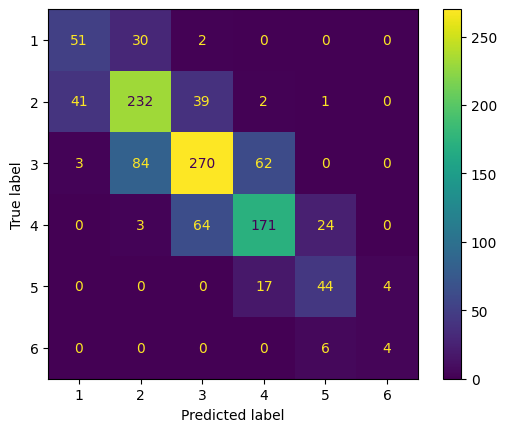

F1 score across fold: 0.6692139790778333
Cohen kappa score across fold: 0.8384892069549477
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.769693	valid's QWK: 0.770241
[50]	train's QWK: 0.820691	valid's QWK: 0.812871
[75]	train's QWK: 0.831798	valid's QWK: 0.825369
[100]	train's QWK: 0.838567	valid's QWK: 0.825754
[125]	train's QWK: 0.842077	valid's QWK: 0.82948
[150]	train's QWK: 0.844903	valid's QWK: 0.830664
[175]	train's QWK: 0.847635	valid's QWK: 0.83221
[200]	train's QWK: 0.850076	valid's QWK: 0.832294
[225]	train's QWK: 0.852189	valid's QWK: 0.833356
[250]	train's QWK: 0.854427	valid's QWK: 0.834737
[275]	train's QWK: 0.856686	valid's QWK: 0.834444
[300]	train's QWK: 0.858597	valid's QWK: 0.836697
[325]	train's QWK: 0.860635	valid's QWK: 0.838005
[350]	train's QWK: 0.862181	valid's QWK: 0.836329
[375]	train's QWK: 0.864276	valid's QWK: 0.837425
[400]	train's QWK: 0.865551	valid's QWK:

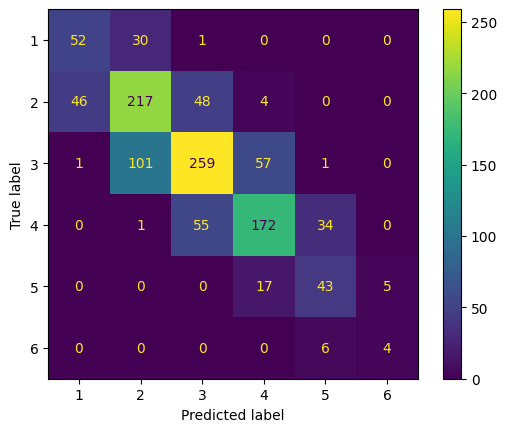

F1 score across fold: 0.6487200997077327
Cohen kappa score across fold: 0.8380046497115263
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.78052	valid's QWK: 0.770161
[50]	train's QWK: 0.827847	valid's QWK: 0.813678
[75]	train's QWK: 0.836226	valid's QWK: 0.817988
[100]	train's QWK: 0.841604	valid's QWK: 0.823859
[125]	train's QWK: 0.843866	valid's QWK: 0.8267
[150]	train's QWK: 0.845975	valid's QWK: 0.827155
[175]	train's QWK: 0.849	valid's QWK: 0.82746
[200]	train's QWK: 0.850858	valid's QWK: 0.830545
[225]	train's QWK: 0.85344	valid's QWK: 0.829849
[250]	train's QWK: 0.855161	valid's QWK: 0.831164
[275]	train's QWK: 0.856375	valid's QWK: 0.8311
[300]	train's QWK: 0.857897	valid's QWK: 0.830705
Early stopping, best iteration is:
[231]	train's QWK: 0.853858	valid's QWK: 0.831563
Evaluated only: QWK


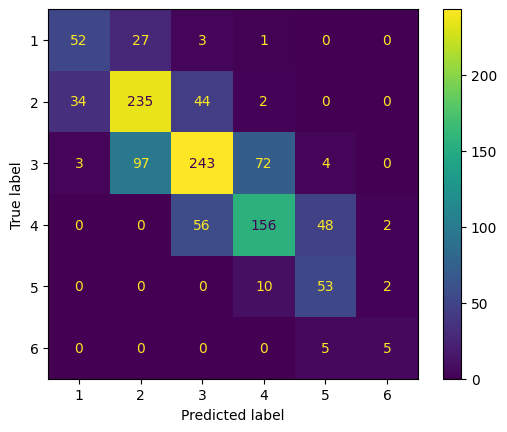

F1 score across fold: 0.6440039379950768
Cohen kappa score across fold: 0.8315628884978306
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.774949	valid's QWK: 0.773671
[50]	train's QWK: 0.823265	valid's QWK: 0.822222
[75]	train's QWK: 0.833214	valid's QWK: 0.828185
[100]	train's QWK: 0.839244	valid's QWK: 0.830798
[125]	train's QWK: 0.843743	valid's QWK: 0.830917
[150]	train's QWK: 0.84654	valid's QWK: 0.831977
[175]	train's QWK: 0.849123	valid's QWK: 0.832889
[200]	train's QWK: 0.851323	valid's QWK: 0.835134
[225]	train's QWK: 0.853946	valid's QWK: 0.834783
[250]	train's QWK: 0.855479	valid's QWK: 0.836772
[275]	train's QWK: 0.85764	valid's QWK: 0.836434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's QWK: 0.8606	valid's QWK: 0.833303
Early stopping, best iteration is:
[248]	train's QWK: 0.855601	valid's QWK: 0.837241
Evaluated only: QWK


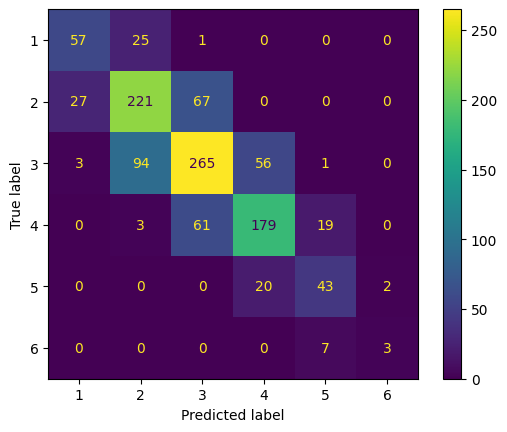

F1 score across fold: 0.6648478377685458
Cohen kappa score across fold: 0.8372408061385748
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.770897	valid's QWK: 0.763567
[50]	train's QWK: 0.822243	valid's QWK: 0.809376
[75]	train's QWK: 0.832504	valid's QWK: 0.818681
[100]	train's QWK: 0.837619	valid's QWK: 0.825458
[125]	train's QWK: 0.841495	valid's QWK: 0.829273
[150]	train's QWK: 0.844971	valid's QWK: 0.829615
[175]	train's QWK: 0.847572	valid's QWK: 0.829227
[200]	train's QWK: 0.849305	valid's QWK: 0.83199
[225]	train's QWK: 0.852061	valid's QWK: 0.831494
[250]	train's QWK: 0.854109	valid's QWK: 0.83105
[275]	train's QWK: 0.855415	valid's QWK: 0.830999
Early stopping, best iteration is:
[220]	train's QWK: 0.851296	valid's QWK: 0.832619
Evaluated only: QWK


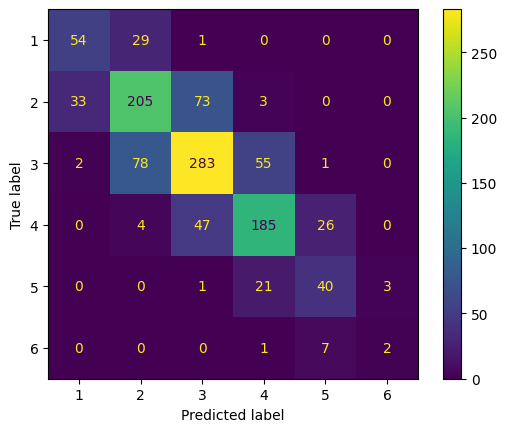

F1 score across fold: 0.6660488499255579
Cohen kappa score across fold: 0.832618601278034
fold 6
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.775037	valid's QWK: 0.777352
[50]	train's QWK: 0.822849	valid's QWK: 0.827308
[75]	train's QWK: 0.834459	valid's QWK: 0.835824
[100]	train's QWK: 0.840307	valid's QWK: 0.840014
[125]	train's QWK: 0.843765	valid's QWK: 0.841642
[150]	train's QWK: 0.845673	valid's QWK: 0.845751
[175]	train's QWK: 0.849042	valid's QWK: 0.848024
[200]	train's QWK: 0.851465	valid's QWK: 0.848452
[225]	train's QWK: 0.853515	valid's QWK: 0.849553
[250]	train's QWK: 0.855643	valid's QWK: 0.85127
[275]	train's QWK: 0.857656	valid's QWK: 0.854776
[300]	train's QWK: 0.859333	valid's QWK: 0.853317
[325]	train's QWK: 0.860833	valid's QWK: 0.853168
[350]	train's QWK: 0.862923	valid's QWK: 0.854183
[375]	train's QWK: 0.864958	valid's QWK: 0.854751
[400]	train's QWK: 0.866743	valid's QWK:

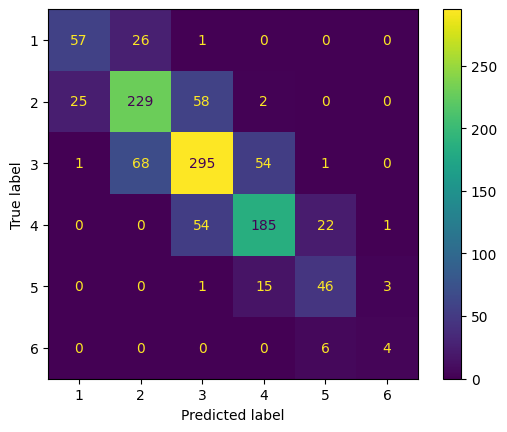

F1 score across fold: 0.7070799200973279
Cohen kappa score across fold: 0.8585982217519668
fold 7
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.773186	valid's QWK: 0.751095
[50]	train's QWK: 0.820885	valid's QWK: 0.796248
[75]	train's QWK: 0.833562	valid's QWK: 0.809252
[100]	train's QWK: 0.840674	valid's QWK: 0.812469
[125]	train's QWK: 0.844239	valid's QWK: 0.817829
[150]	train's QWK: 0.845979	valid's QWK: 0.820259
[175]	train's QWK: 0.849343	valid's QWK: 0.818469
[200]	train's QWK: 0.851687	valid's QWK: 0.821346
[225]	train's QWK: 0.854079	valid's QWK: 0.8228
[250]	train's QWK: 0.856056	valid's QWK: 0.827004
[275]	train's QWK: 0.858563	valid's QWK: 0.828461
[300]	train's QWK: 0.860728	valid's QWK: 0.827981
[325]	train's QWK: 0.862513	valid's QWK: 0.828627
[350]	train's QWK: 0.864066	valid's QWK: 0.827844
Early stopping, best iteration is:
[291]	train's QWK: 0.859821	valid's QWK: 0.830289
Evalu

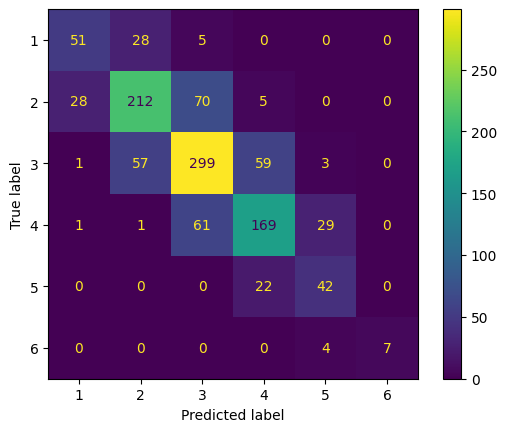

F1 score across fold: 0.6764163848992834
Cohen kappa score across fold: 0.8302888572796374
fold 8
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.770249	valid's QWK: 0.763208
[50]	train's QWK: 0.821767	valid's QWK: 0.825819
[75]	train's QWK: 0.832852	valid's QWK: 0.831835
[100]	train's QWK: 0.839512	valid's QWK: 0.833065
[125]	train's QWK: 0.843104	valid's QWK: 0.83471
[150]	train's QWK: 0.845796	valid's QWK: 0.838237
[175]	train's QWK: 0.848303	valid's QWK: 0.833973
[200]	train's QWK: 0.84959	valid's QWK: 0.835562
[225]	train's QWK: 0.851921	valid's QWK: 0.838812
[250]	train's QWK: 0.854004	valid's QWK: 0.839584
[275]	train's QWK: 0.855466	valid's QWK: 0.83893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's QWK: 0.857417	valid's QWK: 0.840936
[325]	train's QWK: 0.859314	valid's QWK: 0.838871
Early stopping, best iteration is:
[262]	train's QWK: 0.854662	val

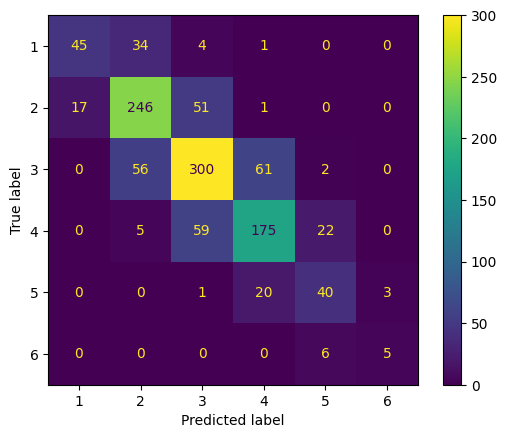

F1 score across fold: 0.7014555116467974
Cohen kappa score across fold: 0.8415570681122246
fold 9
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.766392	valid's QWK: 0.746677
[50]	train's QWK: 0.823415	valid's QWK: 0.809415
[75]	train's QWK: 0.832816	valid's QWK: 0.818072
[100]	train's QWK: 0.838731	valid's QWK: 0.823253
[125]	train's QWK: 0.842833	valid's QWK: 0.828567
[150]	train's QWK: 0.84577	valid's QWK: 0.829637
[175]	train's QWK: 0.848481	valid's QWK: 0.829812
[200]	train's QWK: 0.850073	valid's QWK: 0.830694
[225]	train's QWK: 0.853118	valid's QWK: 0.828712
[250]	train's QWK: 0.854909	valid's QWK: 0.829242
[275]	train's QWK: 0.856728	valid's QWK: 0.830831
Early stopping, best iteration is:
[204]	train's QWK: 0.850597	valid's QWK: 0.832293
Evaluated only: QWK


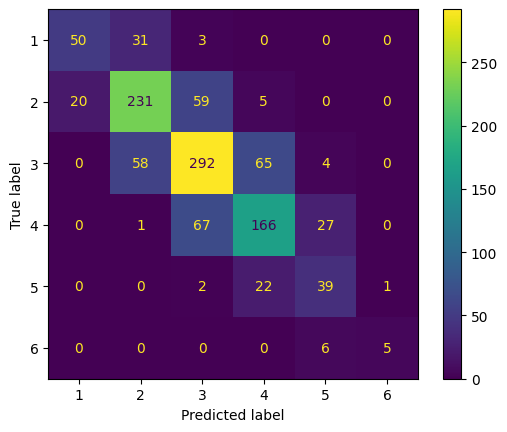

F1 score across fold: 0.6785669883279485
Cohen kappa score across fold: 0.8322926382789929
fold 10
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.776319	valid's QWK: 0.777201
[50]	train's QWK: 0.824056	valid's QWK: 0.809172
[75]	train's QWK: 0.834259	valid's QWK: 0.820996
[100]	train's QWK: 0.839674	valid's QWK: 0.827635
[125]	train's QWK: 0.842906	valid's QWK: 0.830074
[150]	train's QWK: 0.845214	valid's QWK: 0.828246
[175]	train's QWK: 0.847927	valid's QWK: 0.829177
[200]	train's QWK: 0.850432	valid's QWK: 0.8309
[225]	train's QWK: 0.852742	valid's QWK: 0.831893
[250]	train's QWK: 0.854435	valid's QWK: 0.832976
[275]	train's QWK: 0.856676	valid's QWK: 0.83354
[300]	train's QWK: 0.858601	valid's QWK: 0.836906
[325]	train's QWK: 0.860954	valid's QWK: 0.837118
[350]	train's QWK: 0.862005	valid's QWK: 0.834719
[375]	train's QWK: 0.863385	valid's QWK: 0.837875
[400]	train's QWK: 0.865689	valid's QWK:

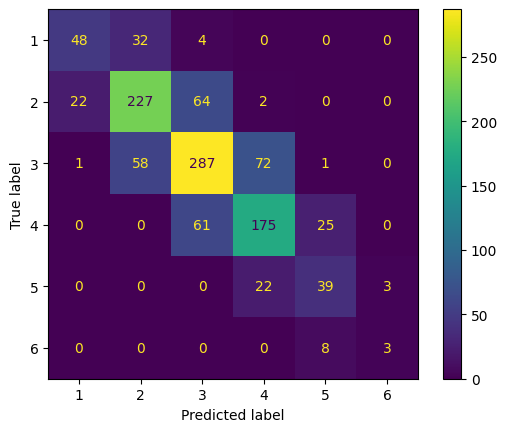

F1 score across fold: 0.674496902259211
Cohen kappa score across fold: 0.8392725119922702
fold 11
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.777736	valid's QWK: 0.777798
[50]	train's QWK: 0.821905	valid's QWK: 0.816313
[75]	train's QWK: 0.833832	valid's QWK: 0.827351
[100]	train's QWK: 0.838812	valid's QWK: 0.833277
[125]	train's QWK: 0.842091	valid's QWK: 0.835232
[150]	train's QWK: 0.845763	valid's QWK: 0.837676
[175]	train's QWK: 0.84825	valid's QWK: 0.838689
[200]	train's QWK: 0.85079	valid's QWK: 0.840492
[225]	train's QWK: 0.85348	valid's QWK: 0.841142
[250]	train's QWK: 0.855977	valid's QWK: 0.842157
[275]	train's QWK: 0.857973	valid's QWK: 0.841787
[300]	train's QWK: 0.8594	valid's QWK: 0.841597
Early stopping, best iteration is:
[233]	train's QWK: 0.853745	valid's QWK: 0.842348
Evaluated only: QWK


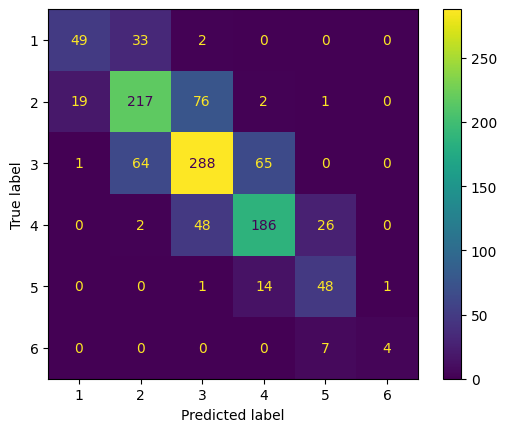

F1 score across fold: 0.6857204468243033
Cohen kappa score across fold: 0.8423475402560298
fold 12
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.776111	valid's QWK: 0.778711
[50]	train's QWK: 0.826299	valid's QWK: 0.829109
[75]	train's QWK: 0.836781	valid's QWK: 0.83529
[100]	train's QWK: 0.839841	valid's QWK: 0.839649
[125]	train's QWK: 0.843192	valid's QWK: 0.841021
[150]	train's QWK: 0.846527	valid's QWK: 0.840834
[175]	train's QWK: 0.849324	valid's QWK: 0.842014
[200]	train's QWK: 0.851125	valid's QWK: 0.842837
[225]	train's QWK: 0.852923	valid's QWK: 0.842623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	train's QWK: 0.854815	valid's QWK: 0.842994
[275]	train's QWK: 0.856692	valid's QWK: 0.842645
[300]	train's QWK: 0.858392	valid's QWK: 0.842633
[325]	train's QWK: 0.860752	valid's QW

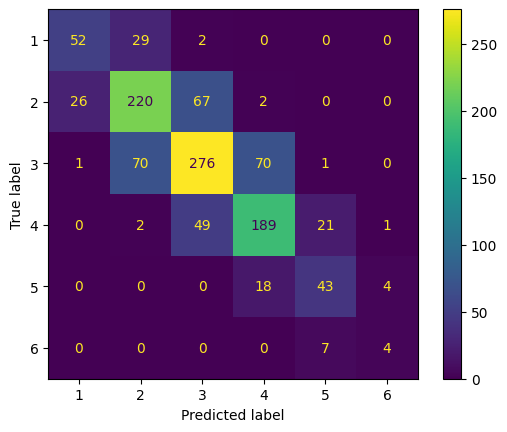

F1 score across fold: 0.6790554872155558
Cohen kappa score across fold: 0.8443250465355087
fold 13
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.770277	valid's QWK: 0.781454
[50]	train's QWK: 0.823624	valid's QWK: 0.817267
[75]	train's QWK: 0.835834	valid's QWK: 0.825979
[100]	train's QWK: 0.841381	valid's QWK: 0.828334
[125]	train's QWK: 0.845284	valid's QWK: 0.828283
[150]	train's QWK: 0.847149	valid's QWK: 0.828546
Early stopping, best iteration is:
[94]	train's QWK: 0.840502	valid's QWK: 0.83124
Evaluated only: QWK


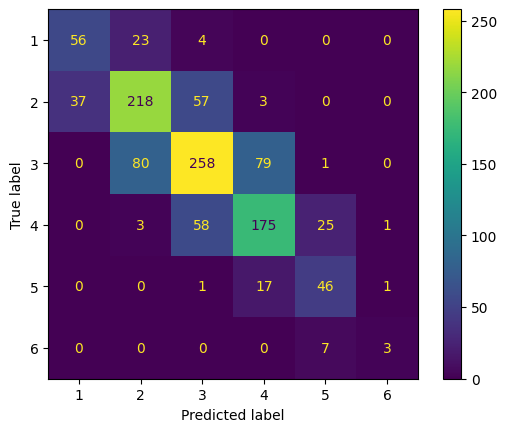

F1 score across fold: 0.6550931923101388
Cohen kappa score across fold: 0.831240121980532
fold 14
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.769691	valid's QWK: 0.783748
[50]	train's QWK: 0.820415	valid's QWK: 0.829864
[75]	train's QWK: 0.831683	valid's QWK: 0.837054
[100]	train's QWK: 0.838063	valid's QWK: 0.841977
[125]	train's QWK: 0.841927	valid's QWK: 0.846447
[150]	train's QWK: 0.845243	valid's QWK: 0.846496
[175]	train's QWK: 0.848024	valid's QWK: 0.847135
[200]	train's QWK: 0.849893	valid's QWK: 0.844581
Early stopping, best iteration is:
[145]	train's QWK: 0.844908	valid's QWK: 0.847557
Evaluated only: QWK


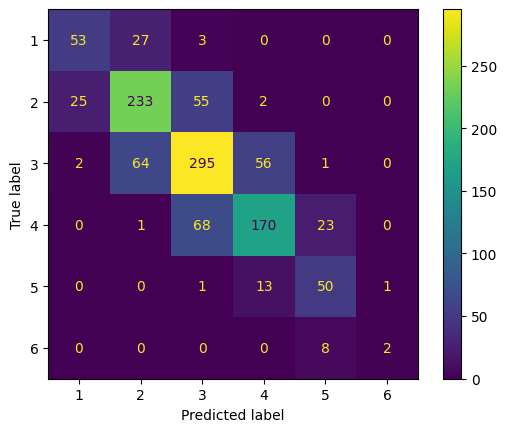

F1 score across fold: 0.6949888108210309
Cohen kappa score across fold: 0.8475569234708895
fold 15
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.776139	valid's QWK: 0.803343
[50]	train's QWK: 0.820945	valid's QWK: 0.837892
[75]	train's QWK: 0.832552	valid's QWK: 0.838872
[100]	train's QWK: 0.839046	valid's QWK: 0.84099
[125]	train's QWK: 0.842019	valid's QWK: 0.844378
[150]	train's QWK: 0.844247	valid's QWK: 0.844922
[175]	train's QWK: 0.847437	valid's QWK: 0.84607
[200]	train's QWK: 0.848838	valid's QWK: 0.849371
[225]	train's QWK: 0.8513	valid's QWK: 0.850596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	train's QWK: 0.85393	valid's QWK: 0.851817
[275]	train's QWK: 0.855607	valid's QWK: 0.851128
[300]	train's QWK: 0.856938	valid's QWK: 0.850781
Early stopping, best iteration is:
[231]	train's QWK: 0.851424	valid's QWK: 0.852278
Evaluated only: QWK


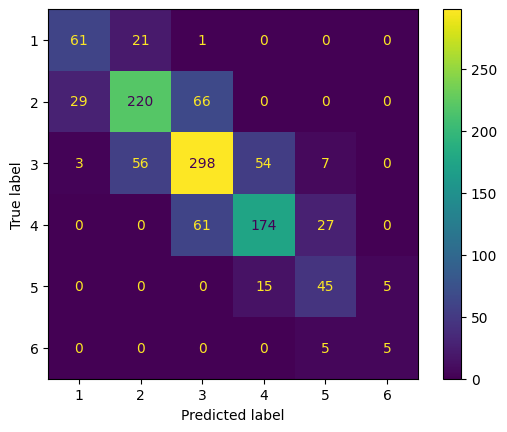

F1 score across fold: 0.6973012265520644
Cohen kappa score across fold: 0.852277642391328
Mean F1 score across 15 folds: 0.6762006383618938
Mean Cohen kappa score across 15 folds: 0.8398448483086863


In [19]:
n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]

i=1
for train_index, test_index in skf.split(X, y_split):
   
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    
   
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.05,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.3,
                reg_alpha = 0.7,
                reg_lambda = 0.1,
                n_estimators=700,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                verbosity = - 1)

    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
    models.append(predictor)
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    oof[test_index]=predictions_fold
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1

mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

print("="*50)
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')
print("="*50)

In [20]:
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# Tfidf
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# CountVectorizer
test_tfid = vectorizer_cnt.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

for i in range(6):
    test_feats[f'deberta_oof_{i}'] = predicted_score[:, i]

# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))
test_feats.head(3)

Features number:  21905


,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,...,tfid_cnt_2166,tfid_cnt_2167,tfid_cnt_2168,tfid_cnt_2169,deberta_oof_0,deberta_oof_1,deberta_oof_2,deberta_oof_3,deberta_oof_4,deberta_oof_5
0,000d118,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0.006567,0.268685,0.699054,0.024991,0.000481,0.000221
1,000fe60,5,5,5,5,5,5,5,4,3,...,0,0,0,0,0.000421,0.030371,0.911969,0.056908,0.000270,0.000061
2,001ab80,4,4,4,4,4,4,4,4,4,...,0,0,0,0,0.000975,0.001574,0.017888,0.448237,0.523299,0.008026


In [21]:
probabilities = []
for model in models:
    proba= model.predict(test_feats[feature_select])+ a
    probabilities.append(proba)

predictions = np.mean(probabilities, axis=0)

predictions = np.round(predictions.clip(1, 6))

print(predictions)


[2. 3. 5.]


In [22]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=predictions
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,5
